# Scratchpad to study the factorization problem

In [211]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
import math
import pickle
import subprocess
import sys
from dataclasses import dataclass
from pathlib import Path
from tqdm import tqdm

sys.path.append(str(Path("..").resolve()))
save_dir = Path(".").resolve() / "results"

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from matplotlib import rc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.mlp import TransformerFeedForward
from models.normalization import RMSNorm
from visualization.graph import build_1L_graph, build_1L_graph_tokens

DEVICE = torch.device("cuda:0")
SEED = None
SEED = 1
if SEED:
    RNG = np.random.default_rng(SEED)
    np.random.seed(seed=SEED)
    torch.manual_seed(seed=SEED)

Data Generation

In [213]:
vocab_size = 2
vocab_size = 4
bsz = 2048
length = 12
sparsity_index = 5

# we create a modular addition problem on some subset of the input only
data = np.random.rand(bsz, length) // (1 / vocab_size)
targets = data[:, :sparsity_index].sum(axis=1) % vocab_size
# data = data.repeat(2, axis=1)

test_bsz = 128
test_data = np.random.rand(test_bsz, length) // (1 / vocab_size)
test_targets = test_data[:, :sparsity_index].sum(axis=1) % vocab_size
# test_data = test_data.repeat(2, axis=1)


# length = 24

In [214]:
print(f"Total number of unique sequences {vocab_size ** length}")

Total number of unique sequences 16777216


Model

In [215]:
class SoftmaxLayer(nn.Module):
    def __init__(self, emb_dim):
        super(SoftmaxLayer, self).__init__()
        self.emb_dim = emb_dim
        self.query = nn.Linear(emb_dim, 1, bias=False)
        self.value = nn.Linear(emb_dim, emb_dim, bias=False)

    def forward(self, x, verbose=False):
        # x: [bsz, seq_len, emb_dim]
        query = self.query.weight
        key = x
        value = self.value(x)

        attn = query @ key.transpose(-1, -2) / math.sqrt(self.emb_dim)
        attn = F.softmax(attn, dim=-1)
        out = (attn @ value).squeeze(1)
        if verbose:
            return out, attn.squeeze(1)
        return out

In [216]:
@dataclass
class MLPConfig:
    activation: float = "gelu"
    emb_dim: bool = None
    ffn_dim: bool = None
    ffn_bias: bool = False
    ffn_dropout: float = 0

    def __post_init__(self):
        if self.ffn_dim is None:
            self.ffn_dim = 4 * self.emb_dim


class Model(nn.Module):
    def __init__(self, emb_dim, vocab_size, ffn_dim=None):
        if ffn_dim is None:
            ffn_dim = 4 * emb_dim
        super(Model, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Embedding(length, emb_dim)

        self.softmax = SoftmaxLayer(emb_dim)
        config = MLPConfig(
            emb_dim=emb_dim,
            ffn_dim=ffn_dim,
            ffn_bias=True,
            activation="gelu",
        )
        self.mlp = TransformerFeedForward(config)

        self.output = nn.Linear(emb_dim, vocab_size, bias=False)
        self.output.weight = self.token_emb.weight

        self.norm1 = RMSNorm()
        self.norm2 = RMSNorm()

    def forward(self, x, verbose=False):
        out = self.token_emb(x) + self.pos_emb.weight
        out = self.softmax(self.norm1(out), verbose=verbose)
        if verbose:
            out, attn = out
        out = out + self.mlp(self.norm2(out))
        out = self.output(out)
        if verbose:
            return out, attn
        return out

Model Selection

In [217]:
emb_dim = 32
ffn_dim = 4 * emb_dim
# ffn_dim = 10
vocab_size = 4
X = torch.from_numpy(data.astype(int))
torch.manual_seed(20)
model = Model(emb_dim=emb_dim, vocab_size=vocab_size, ffn_dim=ffn_dim)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
model.to(device=DEVICE)

Number of parameters: 9920


Model(
  (token_emb): Embedding(4, 32)
  (pos_emb): Embedding(12, 32)
  (softmax): SoftmaxLayer(
    (query): Linear(in_features=32, out_features=1, bias=False)
    (value): Linear(in_features=32, out_features=32, bias=False)
  )
  (mlp): TransformerFeedForward(
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=4, bias=False)
  (norm1): RMSNorm()
  (norm2): RMSNorm()
)

In [218]:
import copy
init_weights = copy.deepcopy(model.state_dict())

In [219]:
model.load_state_dict(init_weights)

<All keys matched successfully>

Training

In [195]:
niter = 10_000 # 2
# niter = 3_000 # 2
# niter = 7_000 # 2 -> 4

all_losses = {}
all_test_losses = {}
all_accs = {}
all_test_accs = {}
all_attns = {}
all_weights = {}
names = ["Adam"] #['SGD', 'Adam', 'AdamLN', 'SGDLN']

X = torch.from_numpy(data).to(dtype=torch.long, device=DEVICE)
Y = torch.from_numpy(targets).to(dtype=torch.long, device=DEVICE)

X_test = torch.from_numpy(test_data).to(dtype=torch.long, device=DEVICE)
Y_test = torch.from_numpy(test_targets).to(dtype=torch.long, device=DEVICE)

# L1 regularization
lambda_l1 = 1e-4

for name in names:
    print(name, flush=True)
    if name[:3] == "SGD":
        lr = 1e-1
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    else:
        # lr = 1e-3 # emb_dim == 8
        # lr = 1e-2 # emb_dim == 4
        # lr = 1e-3 # emb_dim == 4
        # lr = 1e-2 # emb_dim == 2
        lr = 1e-2 # emb_dim == 2 & reg_l1
        lr = 1e-2 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20
        lr = 1e-3 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20 2 -> 5
        # lr = 1e-3 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20 2 -> 4 -> 6
        # lr = 1e-3 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & model_seed 20 2 -> 4 -> 6
        # lr = 1e-1 # emb_dim == 2 & ffn_dim == 32 & reg_l1 & vocab_size 6 model_seed 
        # lr = 1e-2 # emb_dim == 2 & ffn_dim == 8 & reg_l1 & model_seed 10000
        # lr = 1e-2 # emb_dim == 2 & model_seed 200
        optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

    losses = torch.zeros(niter)
    test_losses = torch.zeros(niter)
    accs = torch.zeros(niter)
    test_accs = torch.zeros(niter)
    attns = torch.zeros((niter, test_bsz, length))
    weights = []

    for i in (bar := tqdm(range(niter))):
        optimizer.zero_grad()

        # compute loss
        score = model(X, verbose=False)
        loss = F.cross_entropy(score.view((-1, vocab_size)), Y.view(-1))
        reg_loss = lambda_l1 * sum(p.abs().sum() for p in model.parameters())

        loss.backward()
        # reg_loss.backward()
        optimizer.step()

        # record statistics
        with torch.no_grad():
            losses[i] = loss.item()
            accs[i] = (score.argmax(-1) == Y).float().mean()
            score_test, attn = model(X_test, verbose=True)
            test_losses[i] = F.cross_entropy(score_test.view((-1, vocab_size)), Y_test.view(-1))
            test_accs[i] = (score_test.argmax(-1) == Y_test).float().mean()
            attns[i] = attn
            weights.append(copy.deepcopy(model.state_dict()))
        
        bar.set_postfix(loss=losses[i].item(), acc=accs[i].item(), test_acc=test_accs[i].item())

    all_losses[name] = losses
    all_test_losses[name] = test_losses
    all_accs[name] = accs
    all_test_accs[name] = test_accs
    all_attns[name] = attns

Adam


  0%|          | 34/10000 [00:00<00:59, 166.69it/s, acc=0.263, loss=1.39, test_acc=0.188]

100%|██████████| 10000/10000 [00:46<00:00, 215.06it/s, acc=1, loss=0.000327, test_acc=0.227] 


In [196]:
score_test[:3]

tensor([[-14.9263,   8.1454,  -6.9706, -21.4630],
        [ 18.2373, -22.7396,   7.7786,  -9.9422],
        [ -8.9941,  41.9807, -16.9965, -19.7669]], device='cuda:0')

In [197]:
X_test[:3]

tensor([[3, 0, 0, 0, 0, 1, 0, 2, 1, 3, 2, 2],
        [1, 2, 0, 2, 2, 2, 1, 3, 1, 0, 3, 3],
        [1, 2, 0, 0, 3, 2, 3, 0, 1, 3, 1, 0]], device='cuda:0')

In [198]:
Y_test[:3]

tensor([3, 3, 2], device='cuda:0')

In [199]:
score_test, attn = model(X_test, verbose=True)
(score_test.argmax(-1) == Y_test).float().mean()

tensor(0.2266, device='cuda:0')

In [200]:
trained_model = copy.deepcopy(model.state_dict())

In [201]:
model.load_state_dict(trained_model)

<All keys matched successfully>

In [202]:
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

# save model
torch.save(model.state_dict(), save_dir / f"{name}.pt")

with open(save_dir / "losses.pkl", "wb") as f:
    pickle.dump(all_losses, f)
with open(save_dir / "accs.pkl", "wb") as f:
    pickle.dump(all_accs, f)
with open(save_dir / "attns.npy", "wb") as f:
    np.save(f, all_attns["Adam"])

In [203]:
all_losses_4 = copy.deepcopy(all_losses)
all_test_losses_4 = copy.deepcopy(all_test_losses)
all_accs_4 = copy.deepcopy(all_accs)
all_test_accs_4 = copy.deepcopy(all_test_accs)
all_attns_4 = copy.deepcopy(all_attns)

In [125]:
all_accs_2 = copy.deepcopy(all_accs)
all_test_accs_2 = copy.deepcopy(all_test_accs)

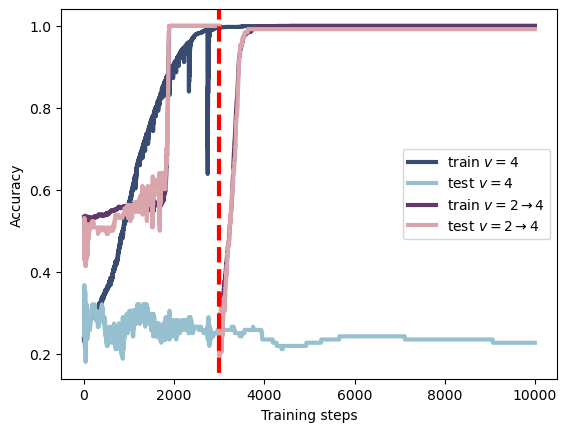

In [152]:
plt.plot(all_accs_4['Adam'], label=r"train $v=4$", color="#3a4b71", linewidth=3)
plt.plot(all_test_accs_4['Adam'], label=r"test $v=4$", color="#96c0cf", linewidth=3)
plt.plot(range(0, 3000), all_accs_2['Adam'], label=r"train $v=2 \rightarrow 4$", color="#613969", linewidth=3)
plt.plot(range(0, 3000), all_test_accs_2['Adam'], label=r"test $v=2 \rightarrow 4$", color="#daa4ac", linewidth=3)
plt.plot(range(3000, 10000), all_accs['Adam'], color="#613969", linewidth=3)
plt.plot(range(3000, 10000), all_test_accs['Adam'], color="#daa4ac", linewidth=3)
ylim = plt.ylim()
plt.vlines(3000, 0.1, 1.1, color="red", linestyle="--", linewidth=3)
plt.ylim(ylim)
plt.ylabel("Accuracy")
plt.xlabel("Training steps")
plt.legend()

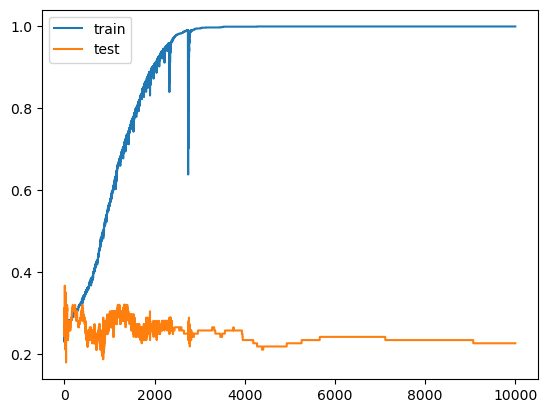

In [176]:
plt.plot(all_accs["Adam"], label="train")
plt.plot(all_test_accs["Adam"], label="test")
plt.legend()

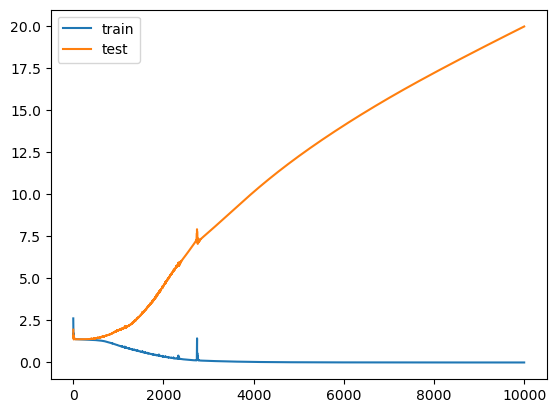

In [177]:
plt.plot(all_losses["Adam"], label="train")
plt.plot(all_test_losses["Adam"], label="test")
plt.legend()

Visualize attention evolution

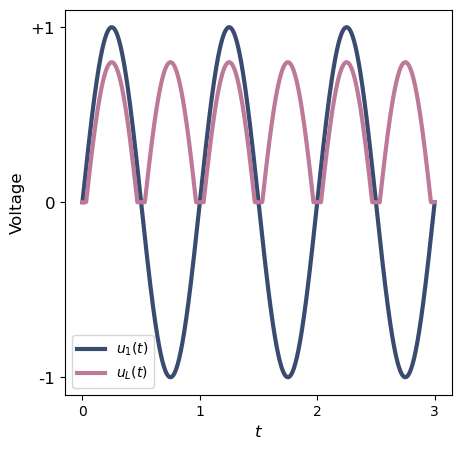

In [82]:
t = np.linspace(0, 3, 1001)
plt.figure(figsize=(5, 5))
plt.plot(t, np.sin(2 * np.pi * t), linewidth=3, color='#3a4b71', label=r'$u_{1}(t)$')
masked = np.sin(2 * np.pi * t) - 0.2
masked[masked < 0] = 0
masked2 = - np.sin(2 * np.pi * t) - 0.2
masked2[masked2 < 0] = 0
plt.plot(t, masked + masked2, linewidth=3, color='#bd7a98', label=r'$u_{L}(t)$')
plt.yticks([-1, 0, +1], ['-1', '0', '+1'], fontsize=12)
plt.xticks([0, 1, 2, 3], fontsize=10)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel('Voltage (V)', fontsize=12)
plt.legend()

In [280]:
attns = np.load(save_dir / "attns.npy", allow_pickle=True)
attns.shape

(4000, 128, 12)

In [49]:
pal = sns.color_palette('seismic')
# pal = sns.cubehelix_palette()
print(f"{pal.as_hex()=}")
pal.as_hex()

pal.as_hex()=['#0000b1', '#2525ff', '#b5b5ff', '#ffb5b5', '#ff2525', '#c80000']


['#0000b1', '#2525ff', '#b5b5ff', '#ffb5b5', '#ff2525', '#c80000']

In [50]:
pal = sns.cubehelix_palette()
print(f"{pal.as_hex()=}")
pal.as_hex()

pal.as_hex()=['#edd1cb', '#daa4ac', '#bd7a98', '#945785', '#613969', '#2d1e3e']


['#edd1cb', '#daa4ac', '#bd7a98', '#945785', '#613969', '#2d1e3e']

In [43]:
pal = sns.cubehelix_palette(rot=-0.2)
print(f"{pal.as_hex()=}")
pal.as_hex()

pal.as_hex()=['#c4e1e5', '#96c0cf', '#719ab6', '#547398', '#3a4b71', '#20243f']


['#c4e1e5', '#96c0cf', '#719ab6', '#547398', '#3a4b71', '#20243f']

In [48]:
pal = sns.cubehelix_palette(rot=0.8)
print(f"{pal.as_hex()=}")
pal.as_hex()

pal.as_hex()=['#c5e5ce', '#a8c28f', '#a19262', '#955f52', '#6f364f', '#341b39']


['#c5e5ce', '#a8c28f', '#a19262', '#955f52', '#6f364f', '#341b39']

In [247]:
pos

{'$x_{0}$': (0, 0),
 '$x_{1}$': (1, 0),
 '$x_{2}$': (2, 0),
 '$x_{3}$': (3, 0),
 '$x_{4}$': (4, 0),
 '$x_{5}$': (5, 0),
 '$x_{6}$': (6, 0),
 '$x_{7}$': (7, 0),
 '$x_{8}$': (8, 0),
 '$x_{9}$': (9, 0),
 '$x_{10}$': (10, 0),
 '$x_{11}$': (11, 0),
 '$q$': (6.0, -1)}

/usr/bin/pdflatex


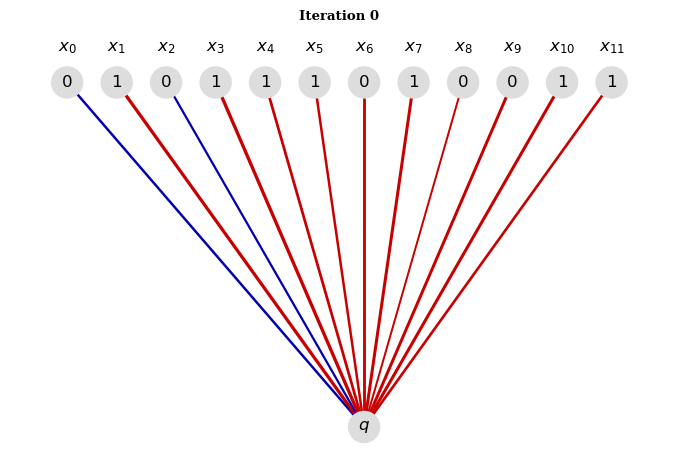

In [297]:
plt.rc("font", family="serif", size=8)

WIDTH = 8.5  # inches (from ICML style file)
HEIGHT = 8.5 / 1.5  # golden ratio
sample = 1

rc("font", family="serif", size=8)
usetex = not subprocess.run(["which", "pdflatex"]).returncode
usetex = False
rc("text", usetex=usetex)
if usetex:
    rc("text.latex", preamble=r"\usepackage{times}")

N = 12

fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
G, pos = build_1L_graph(N)
magnifier = 8 / attns.max()
weights = 0

color_palette = [
    '#c80000',
    '#0000b1',
]


def update(frame):
    global weights

    # update variables
    ax.clear()
    old_weights = weights
    # weights = attns[10 * frame].mean(axis=0)
    weights = attns[10 * frame, sample]
    G, pos = build_1L_graph_tokens(N, tokens=X_test[sample].tolist())
    node_colors = ["#ffffff"]*12 + ["#dddddd"]*12 + ["#dddddd"]
    T = 0.05
    weights = np.exp(weights / T)
    weights /= np.sum(weights)

    # color edges according to updates
    diff = weights - old_weights
    colors = [color_palette[0] if d > 0 else color_palette[1] for d in diff]

    # draw the updated graph
    nx.draw(
        G,
        pos,
        width=magnifier * weights,
        with_labels=True,
        edge_color=colors,
        node_size=500,
        node_color=node_colors,
        labels={rf"$y_{{{i}}}$": j for i, j in enumerate(X_test[sample].tolist())} | {rf"$x_{{{i}}}$": rf"$x_{{{i}}}$" for i in range(N)} | {r"$q$": r"$q$"},
        ax=ax,
    )
    ax.set_title(f"Iteration {10 * frame}", fontweight="bold")


ani_length = 400 - 1
ani = animation.FuncAnimation(fig, update, frames=ani_length, repeat=False)
# ani.save(save_dir / "test.gif", writer="imagemagick", fps=20)
ani.save(save_dir / f"test_{sample}.mp4", writer="ffmpeg", fps=20)

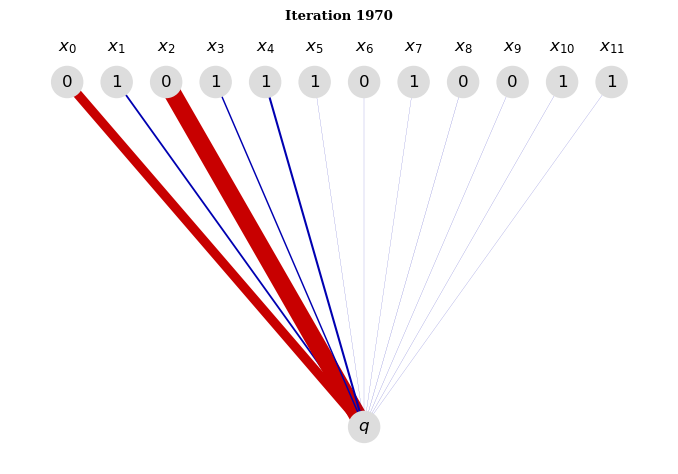

In [298]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
update(197)

Analysis of MLP layers

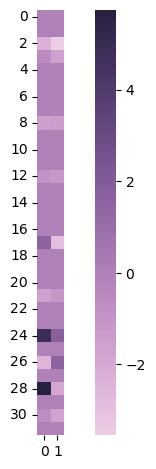

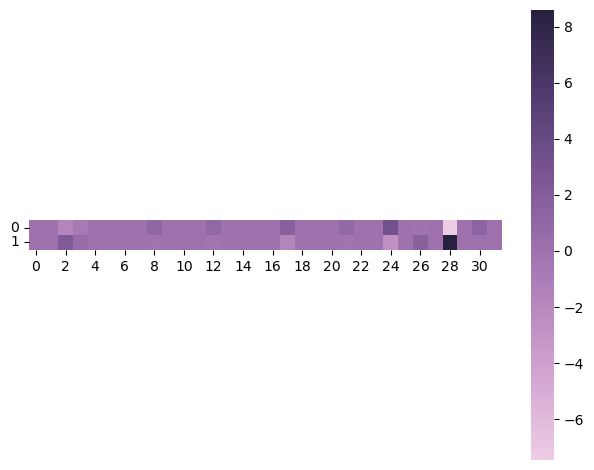

In [504]:
# Example of proposed palette
cmap = sns.cubehelix_palette(rot=0.2, as_cmap=True)
cbar = True
W1 = model.mlp.fc1.weight.cpu().detach().numpy()
s = sns.heatmap(
    W1,
    linewidths=0,
    square=True,
    cmap=cmap,
    cbar=cbar,
    robust=False,
)

# Rotate ylabels
s.set_yticklabels(s.get_yticklabels(), rotation = 0)
plt.tight_layout()
plt.show()

W2 = model.mlp.fc2.weight.cpu().detach().numpy()
s = sns.heatmap(
    W2,
    linewidths=0,
    square=True,
    cmap=cmap,
    cbar=cbar,
    robust=False,
)

# Rotate ylabels
s.set_yticklabels(s.get_yticklabels(), rotation = 0)
plt.tight_layout()
plt.show()

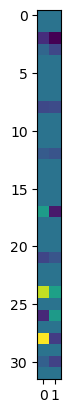

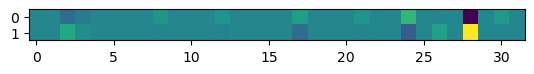

In [505]:
plt.figure()
plt.imshow(model.mlp.fc1.weight.cpu().detach().numpy())
plt.figure()
plt.imshow(model.mlp.fc2.weight.cpu().detach().numpy())

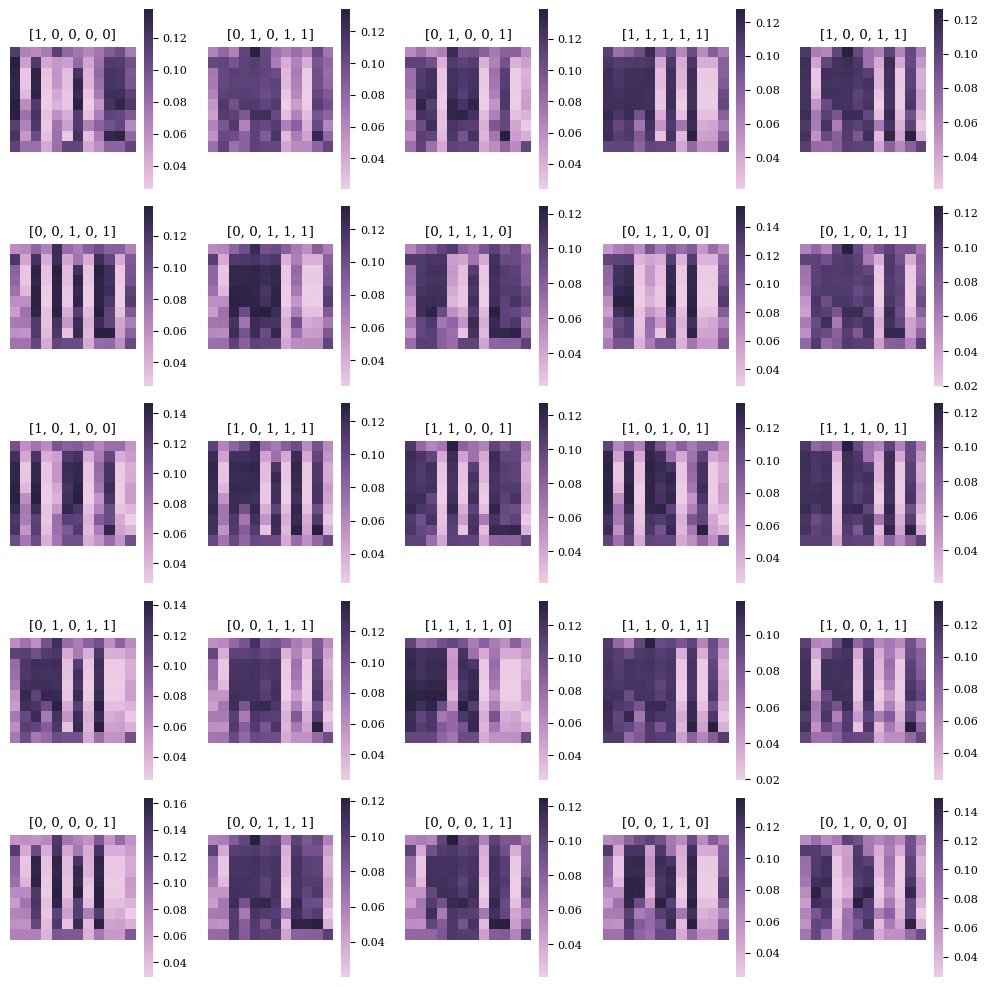

In [667]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
cbar = True
for i in range(25):
    ax = axes[i // 5, i % 5]
    A = attns[::1000,i,:]
    s = sns.heatmap(
        A,
        ax=ax,
        linewidths=0,
        square=True,
        cmap=cmap,
        cbar=cbar,
        robust=False
    )

    # Add input sequence
    ax.set_title(f"{X_test[i,:5].tolist()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

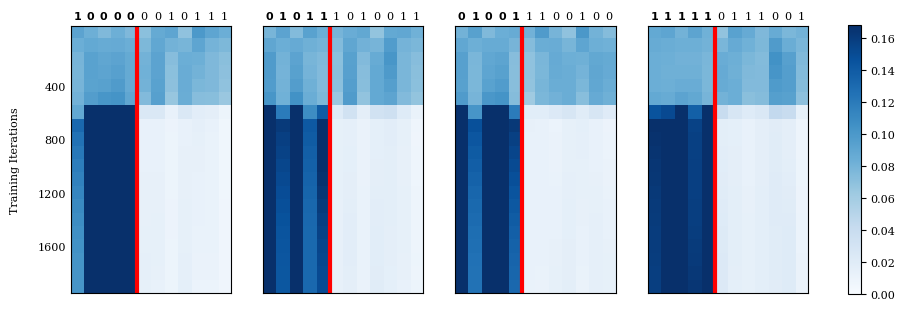

In [282]:
WIDTH=8.5
HEIGHT=8.5/1.5
fig, axes = plt.subplots(1, 4, figsize=(1.2*WIDTH, HEIGHT), sharey=True)

ax = lambda i: axes[i]
ax(0).set_ylabel('Training Iterations\n')
ax(0).set_yticks(range(4, 20, 4))
ax(0).set_yticklabels([f'{i:0>3}' for i in range(400, 2000, 400)])
vmax = attns.max().item()/2
vmin = 0
for i in range(4):
    XX = X_test[i,:].tolist()
    XX = [rf'$\mathbf{{{ii}}}$' if i < 5 else f'{ii}' for i, ii in enumerate(XX)]
    im = ax(i).imshow(attns[:2000:100,i,:], cmap='Blues', vmin=vmin, vmax=vmax)
    ax(i).tick_params(axis='both', which='both', length=0)
    ax(i).set_xticks(list(range(12)))
    ax(i).set_xticklabels(XX, rotation=0)
    ax(i).xaxis.set_ticks_position('top')
    ax(i).vlines([4.5], -0.5, 19.5, color='red', linewidth=3)
    # ax[i // 3, i % 3].set_title(f"{X_test[i,:5].tolist()}")
    # ax[i // 3, i % 3].axis('off')

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.017)

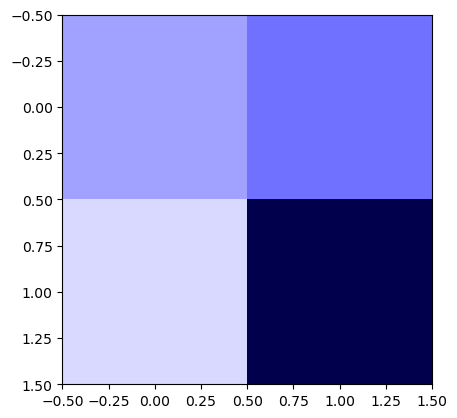

In [412]:
vmax = model.softmax.value.weight.abs().max()
vmin = -vmax
cmap = 'seismic'
plt.imshow(model.softmax.value.weight.cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)

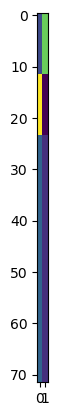

In [413]:
embs = np.vstack([qwe for qwe in model.token_emb.weight.cpu().detach().numpy() for _ in range(12)])
plt.imshow(embs)

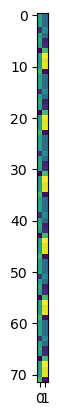

In [414]:
plt.imshow(model.pos_emb.weight.repeat(vocab_size,1).cpu().detach().numpy())

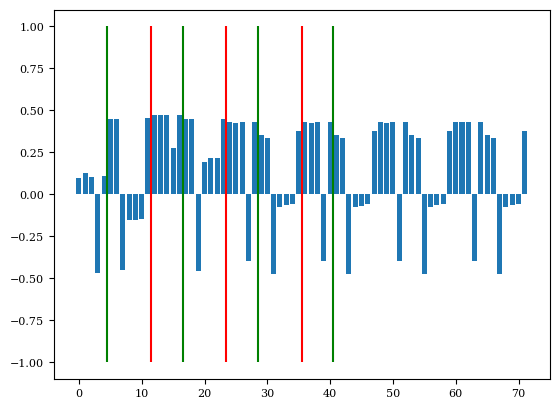

In [671]:
embs = np.vstack([qwe for qwe in model.token_emb.weight.cpu().detach().numpy() for _ in range(12)])
# plt.imshow((zz := model.norm1(torch.from_numpy(embs) + model.pos_emb.weight.repeat(4,1).cpu()).detach().numpy()))
zz = model.norm1(torch.from_numpy(embs) + model.pos_emb.weight.repeat(vocab_size,1).cpu())
attn = model.softmax.query.weight.cpu() @ zz.transpose(-1, -2) / math.sqrt(model.softmax.emb_dim)
plt.bar(range(attn.shape[1]), attn.detach().numpy().flatten())
plt.vlines([11.5, 23.5, 35.5], -1, 1, color='red')
plt.vlines([4.5, 11.5+5, 23.5+5, 35.5+5], -1, 1, color='green')

In [310]:
embs = np.vstack([qwe for qwe in model.token_emb.weight.cpu().detach().numpy() for _ in range(12)])
# plt.imshow((zz := model.norm1(torch.from_numpy(embs) + model.pos_emb.weight.repeat(4,1).cpu()).detach().numpy()))
zz = model.norm1(torch.from_numpy(embs) + model.pos_emb.weight.repeat(vocab_size,1).cpu())
attn = model.softmax.query.weight.cpu() @ zz.transpose(-1, -2) / math.sqrt(model.softmax.emb_dim)
vv = model.softmax.value(zz.cuda()).cpu()
out = attn @ model.softmax.value(zz.cuda()).cpu()
out.shape

torch.Size([1, 2])

In [731]:
# Convert an int to base 4 representation
def int2base(x, base=4, length=5):
    digits = []
    for _ in range(length):
        x, r = divmod(x, base)
        digits.append(r)
    return digits[::-1]

In [732]:
int2base(1)

[0, 0, 0, 0, 1]

In [207]:
x = torch.tensor([[(i // 2**4) % 2, (i // 2**3) % 2, (i // 2**2) % 2, (i // 2**1) % 2, i % 2] + [0]*7 for i in range(32)]).cuda()
# x = torch.tensor([[(i // 2**4) % 2, (i // 2**3) % 2, (i // 2**2) % 2, (i // 2**1) % 2, i % 2] + [1]*7 for i in range(32)]).cuda()
# x = torch.tensor([int2base(i, base=4, length=sparsity_index) + [0]*7 for i in range(1024)]).cuda()
y = x[:,:sparsity_index].sum(dim=1) % 2
y_2 = x[:,:sparsity_index].sum(dim=1) % 4
# x = x.repeat(1,2)
z = model.token_emb(x) + model.pos_emb.weight
z = model.norm1(z)
query = model.softmax.query.weight
key = z
value = model.softmax.value(z)
attn = query @ key.transpose(-1, -2) / math.sqrt(model.softmax.emb_dim)
attn = F.softmax(attn, dim=-1)
out = (attn @ value).squeeze(1)
out2 = out + model.mlp(model.norm2(out))
out3 = model.output(out2)

In [120]:
print(f"{x.shape=}")
print(f"{y.shape=}")
print(f"{z.shape=}")
print(f"{query.shape=}")
print(f"{key.shape=}")
print(f"{value.shape=}")
print(f"{attn.shape=}")
print(f"{out.shape=}")
print(f"{out2.shape=}")
print(f"{out3.shape=}")

x.shape=torch.Size([32, 12])
y.shape=torch.Size([32])
z.shape=torch.Size([32, 12, 2])
query.shape=torch.Size([1, 2])
key.shape=torch.Size([32, 12, 2])
value.shape=torch.Size([32, 12, 2])
attn.shape=torch.Size([32, 1, 12])
out.shape=torch.Size([32, 2])
out2.shape=torch.Size([32, 2])
out3.shape=torch.Size([32, 2])


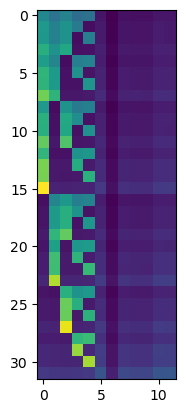

In [180]:
plt.imshow(attn.squeeze().cpu().detach().numpy())

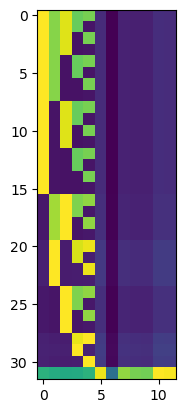

In [181]:
plt.imshow((attn.squeeze()/attn.squeeze().max(dim=-1, keepdim=True).values).cpu().detach().numpy())

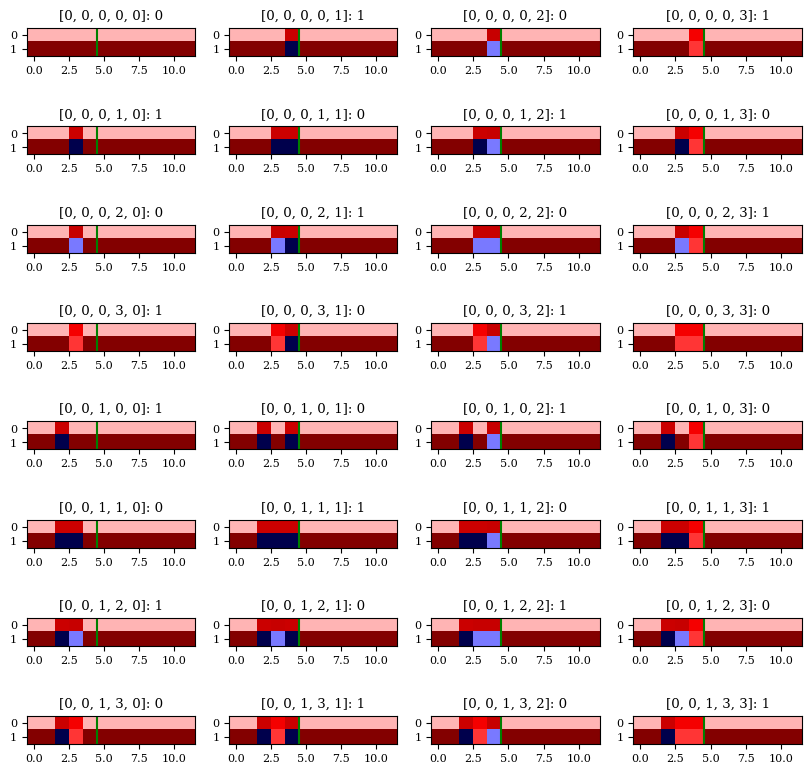

In [742]:
fig, ax = plt.subplots(8, 4, figsize=(10, 10))

# Make the colormap symmetric
vmax = model.token_emb.weight.abs().max().item()
vmin = -vmax
cmap = 'seismic'

for i in range(32):
    ax[i // 4, i % 4].imshow(model.token_emb(x[i]).transpose(0,1).cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax)
    # ax[i // 4, i % 4].axis('off')
    ax[i // 4, i % 4].vlines([4.5], -0.5, 1.5, color='green')
    ax[i // 4, i % 4].set_title(f"{x[i, :5].tolist()}: {y[i].item()}")

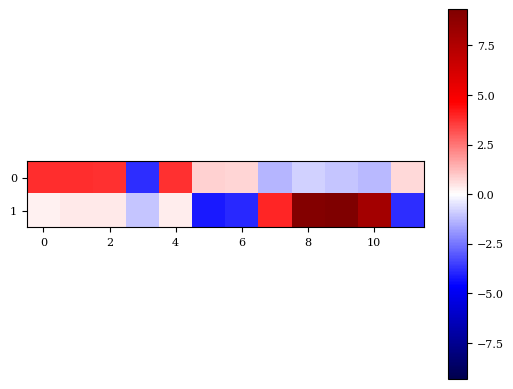

In [746]:
vmax = model.pos_emb.weight.abs().max().item()
vmin = -vmax
cmap = 'seismic'

plt.imshow(model.pos_emb.weight.transpose(0,1).cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax)
# colorbar must be of same size as plot
plt.colorbar()


In [678]:
model.token_emb.weight

Parameter containing:
tensor([[-2.5968e-01,  1.1971e+00],
        [ 1.8100e+00, -8.6154e-01],
        [ 1.1734e-03, -4.8996e-01],
        [-1.3534e-04, -4.8759e-01],
        [-3.3348e-04, -5.0371e-01],
        [ 1.7805e-03, -4.8788e-01]], device='cuda:0', requires_grad=True)

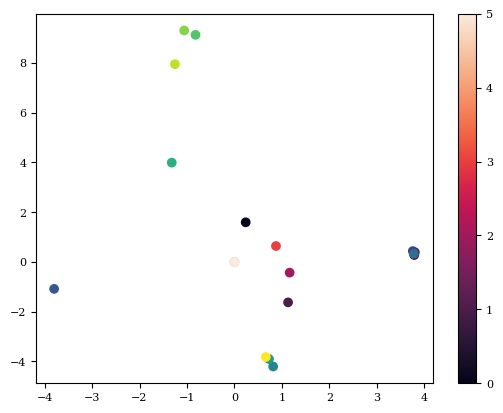

In [747]:
vmax = model.pos_emb.weight.abs().max().item()
vmin = -vmax
cmap = 'seismic'

x_1 = model.pos_emb.weight.transpose(0,1).cpu().detach().numpy()
plt.scatter(x_1[0,:], x_1[1,:], c=np.arange(x_1.shape[1]))
x_2 = model.token_emb.weight.transpose(0,1).cpu().detach().numpy()
plt.scatter(x_2[0,:], x_2[1,:], c=np.arange(x_2.shape[1]), cmap='rocket')

# plt.imshow(model.pos_emb.weight.transpose(0,1).cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar()

In [749]:
x_1.shape

(72, 2)

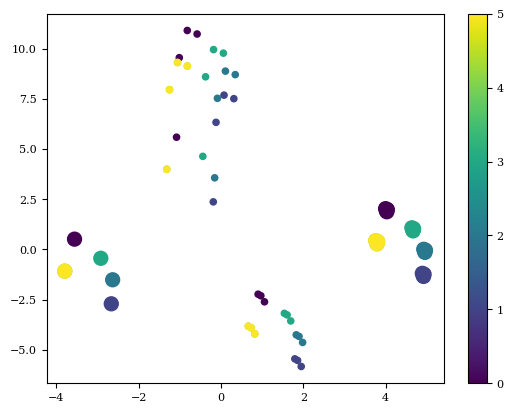

In [754]:
vmax = model.pos_emb.weight.abs().max().item()
vmin = -vmax
cmap = 'seismic'

x_1 = (model.token_emb.weight.unsqueeze(1).cpu().detach().numpy() + model.pos_emb.weight.cpu().detach().numpy()).reshape(-1, 2)
plt.scatter(x_1[:, 0], x_1[:, 1], c=np.arange(x_1.shape[0])//model.pos_emb.weight.shape[0], s=80*(((np.arange(72)%model.pos_emb.weight.shape[0]) < 5))+20)

# plt.imshow(model.pos_emb.weight.transpose(0,1).cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar()

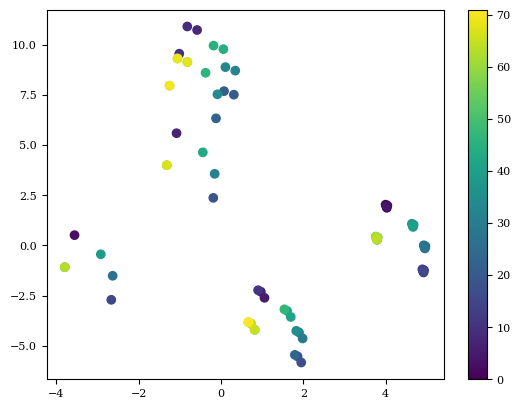

In [752]:
vmax = model.pos_emb.weight.abs().max().item()
vmin = -vmax
cmap = 'seismic'

x_1 = (model.token_emb.weight.unsqueeze(1).cpu().detach().numpy() + model.pos_emb.weight.cpu().detach().numpy()).reshape(-1, 2)
plt.scatter(x_1[:, 0], x_1[:, 1], c=np.arange(x_1.shape[0]))

# plt.imshow(model.pos_emb.weight.transpose(0,1).cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar()

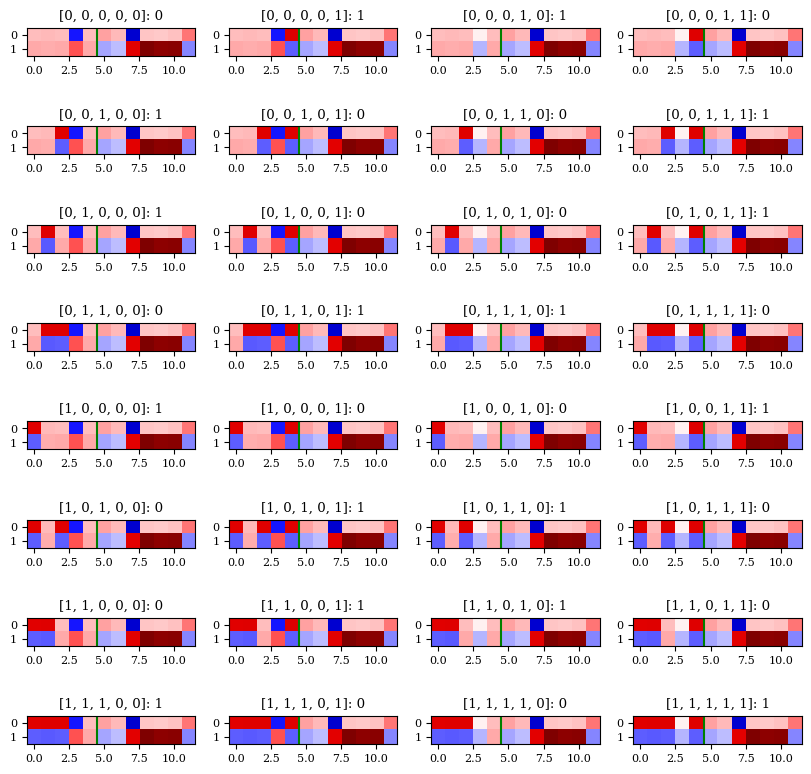

In [679]:
fig, ax = plt.subplots(8, 4, figsize=(10, 10))

# Make the colormap symmetric
vmax = (model.token_emb(x) + model.pos_emb.weight).abs().max().item()
vmin = -vmax
cmap = 'seismic'

for i in range(32):
    ax[i // 4, i % 4].imshow((model.token_emb(x[i]) + model.pos_emb.weight).transpose(0,1).cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax)
    # ax[i // 4, i % 4].axis('off')
    ax[i // 4, i % 4].vlines([4.5], -0.5, 1.5, color='green')
    ax[i // 4, i % 4].set_title(f"{x[i, :5].tolist()}: {y[i].item()}")

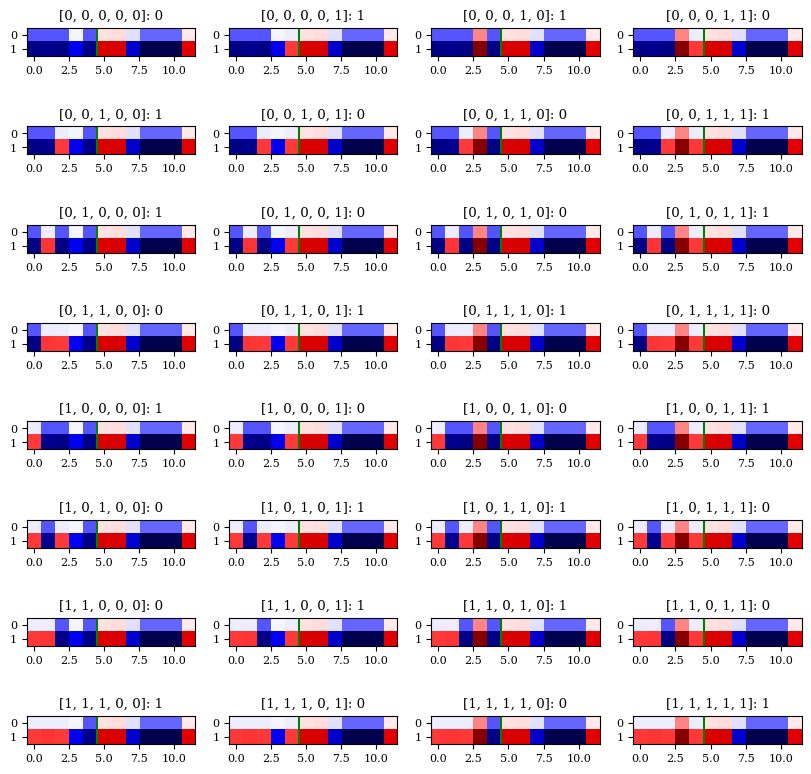

In [680]:
fig, ax = plt.subplots(8, 4, figsize=(10, 10))

# Make the colormap symmetric
vmax = value.abs().max().item()
vmin = -vmax
cmap = 'seismic'

for i in range(32):
    ax[i // 4, i % 4].imshow(value[i].transpose(0,1).cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax)
    # ax[i // 4, i % 4].axis('off')
    ax[i // 4, i % 4].vlines([4.5], -0.5, 1.5, color='green')
    ax[i // 4, i % 4].set_title(f"{x[i, :5].tolist()}: {y[i].item()}")

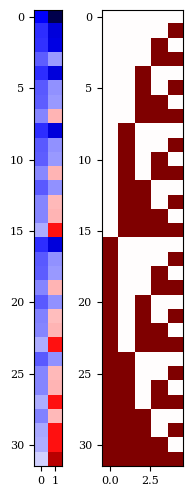

In [681]:
fig, ax = plt.subplots(1, 2, figsize=(2, 5))
vmax = out.abs().max().item()
vmin = -vmax
ax[0].imshow(out.squeeze().cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax)
vmax = x.abs().max().item()
vmin = -vmax
ax[1].imshow(x[:,:5].squeeze().cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto')
# ax[1].axis('off')
fig.tight_layout()



In [755]:
out[[0, 1, 3, 7, 15, 31]]

tensor([[-0.2119, -0.2885],
        [-0.1652, -0.1566],
        [-0.1976, -0.2433],
        [-0.1521, -0.1102],
        [-0.1824, -0.2034],
        [-0.1361, -0.0715]], device='cuda:0', grad_fn=<IndexBackward0>)

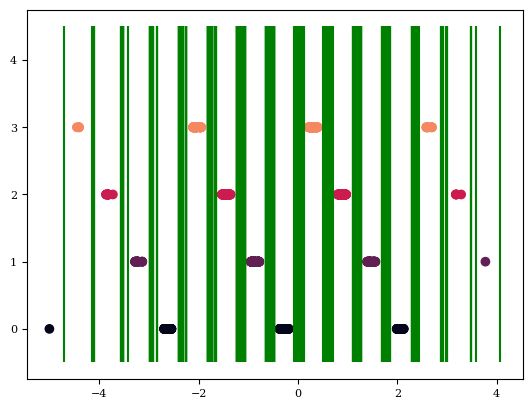

In [797]:
vmax = out.abs().max().item()
vmin = -vmax
out_tmp = out.squeeze().cpu().detach().numpy()
ii = 4
# plt.scatter(out_tmp[:,0], out_tmp[:,1], cmap='rocket', vmin=0, vmax=ii, c=(x[:,:sparsity_index].sum(dim=1) % ii).cpu().detach().numpy())
plt.scatter(10*(out_tmp[:,0] + out_tmp[:,1]), (x[:,:sparsity_index].sum(dim=1) % ii).cpu().detach().numpy(), cmap='rocket', vmin=0, vmax=ii, c=(x[:,:sparsity_index].sum(dim=1) % ii).cpu().detach().numpy())
plt.vlines(10*(out_tmp[:,0] + out_tmp[:,1])+0.3, -0.5, ii + .5, color='green')

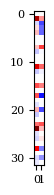

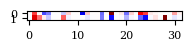

In [757]:
plt.figure(figsize=(2, 2))
vmax = model.mlp.fc1.weight.abs().max().item()
vmin = -vmax
cmap = 'seismic'
plt.imshow(model.mlp.fc1.weight.cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)

plt.figure(figsize=(2, 2))
vmax = model.mlp.fc1.weight.abs().max().item()
vmin = -vmax
plt.imshow(model.mlp.fc2.weight.cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)

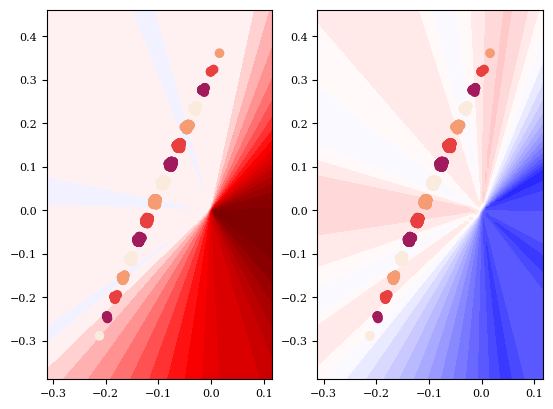

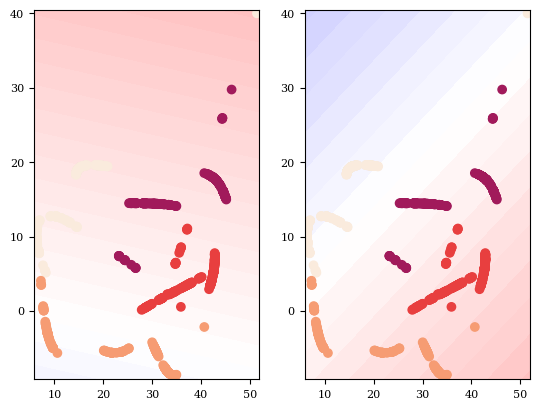

In [802]:
import numpy as np
import matplotlib.pyplot as plt
# Create a grid of x and y values
x_1 = np.linspace(out[:,0].min().item()-0.1, out[:,0].max().item()+0.1, 100)
x_2 = np.linspace(out[:,1].min().item()-0.1, out[:,1].max().item()+0.1, 100)
X_1, X_2 = np.meshgrid(x_1, x_2)
# Evaluate the function on the grid
Z = torch.stack([torch.from_numpy(X_1), torch.from_numpy(X_2)], dim=2).view(-1, 2).float()
Z = (Z.cuda() + model.mlp(model.norm2(Z.cuda())))
Z = model.output(Z)
Z = Z.view(100, 100, -1).cpu().detach().numpy()
vmax = np.max(np.abs(Z))
vmin = -vmax
cmap = 'seismic'
# Create the contour plot
fig, ax = plt.subplots(1, 2)
ax[0].contourf(X_1, X_2, Z[:, :, 0], levels=20, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1].contourf(X_1, X_2, Z[:, :, 1], levels=20, cmap=cmap, vmin=vmin, vmax=vmax)
# plt.contour(X_1, X_2, Z, levels=20)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Contour Plot of f(x,y) = x^2 + y^2')
# plt.show()
out_tmp = out.squeeze().cpu().detach().numpy()
ax[0].scatter(out_tmp[:,0], out_tmp[:,1], cmap='rocket_r', vmin=0, vmax=5, c=y_2.cpu().detach().numpy())
ax[1].scatter(out_tmp[:,0], out_tmp[:,1], cmap='rocket_r', vmin=0, vmax=5, c=y_2.cpu().detach().numpy())

fig, ax = plt.subplots(1, 2)
x_1 = np.linspace(out2[:,0].min().item()-0.5, out2[:,0].max().item()+0.5, 100)
x_2 = np.linspace(out2[:,1].min().item()-0.5, out2[:,1].max().item()+0.5, 100)
X_1, X_2 = np.meshgrid(x_1, x_2)
# Evaluate the function on the grid
Z = torch.stack([torch.from_numpy(X_1), torch.from_numpy(X_2)], dim=2).view(-1, 2).float()
Z = model.output(Z.cuda()).view(100, 100, -1).cpu().detach().numpy()
ax[0].contourf(X_1, X_2, Z[:, :, 0], levels=20, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1].contourf(X_1, X_2, Z[:, :, 1], levels=20, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0].scatter(out2[:,0].cpu().detach().numpy(), out2[:,1].cpu().detach().numpy(), cmap='rocket_r', vmin=0, vmax=5, c=y_2.cpu().detach().numpy())
ax[1].scatter(out2[:,0].cpu().detach().numpy(), out2[:,1].cpu().detach().numpy(), cmap='rocket_r', vmin=0, vmax=5, c=y_2.cpu().detach().numpy())

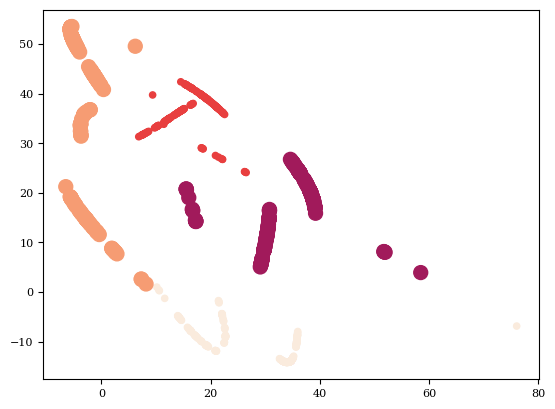

In [799]:
plt.scatter(out3[:,0].cpu().detach().numpy(), out3[:,1].cpu().detach().numpy(), cmap='rocket_r', vmin=0, vmax=5, c=(x[:,:sparsity_index].sum(dim=1) % 4).cpu().detach().numpy(), s=20+80*y.cpu().detach().numpy())

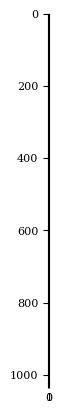

In [800]:
plt.imshow(model.norm2(out).squeeze().cpu().detach().numpy())

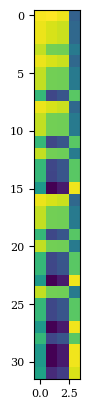

In [ ]:
plt.imshow(model.mlp.fc1(model.norm2(out)).squeeze().cpu().detach().numpy())

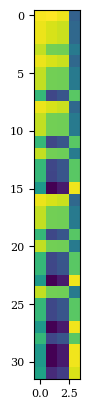

In [ ]:
plt.imshow(model.mlp.fc1(model.norm2(out)).squeeze().cpu().detach().numpy())

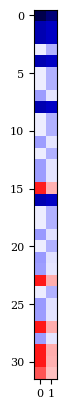

In [ ]:
vmax = model.mlp(model.norm2(out)).abs().max().item()
vmin = -vmax
cmap = 'seismic'
plt.imshow(model.mlp(model.norm2(out)).squeeze().cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)

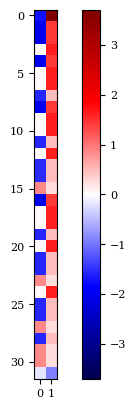

In [ ]:
vmax = out2.abs().max().item()
vmin = -vmax
cmap = 'seismic'
plt.imshow(out2.squeeze().cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()

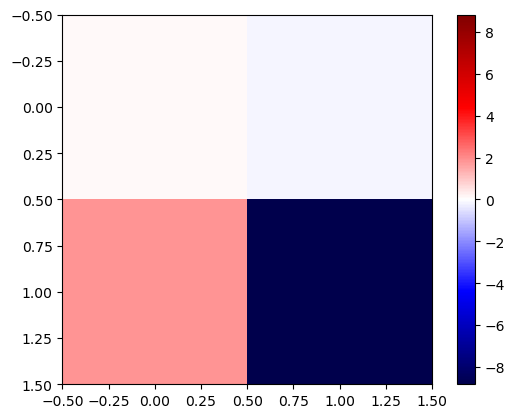

In [325]:
vmax = model.output.weight.abs().max().item()
vmin = -vmax
cmap = 'seismic'
plt.imshow(model.output.weight.cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()

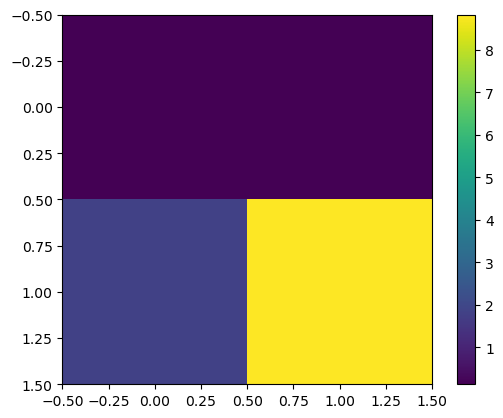

In [326]:
plt.imshow(model.output.weight.cpu().detach().abs().numpy())
plt.colorbar()

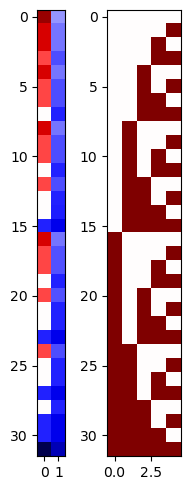

In [327]:
fig, ax = plt.subplots(1, 2, figsize=(2, 5))
vmax = out.abs().max().item()
vmin = -vmax
ax[0].imshow(out.squeeze().cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax)
vmax = x.abs().max().item()
vmin = -vmax
ax[1].imshow(x[:,:5].squeeze().cpu().detach().numpy(), cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto')
# ax[1].axis('off')
fig.tight_layout()



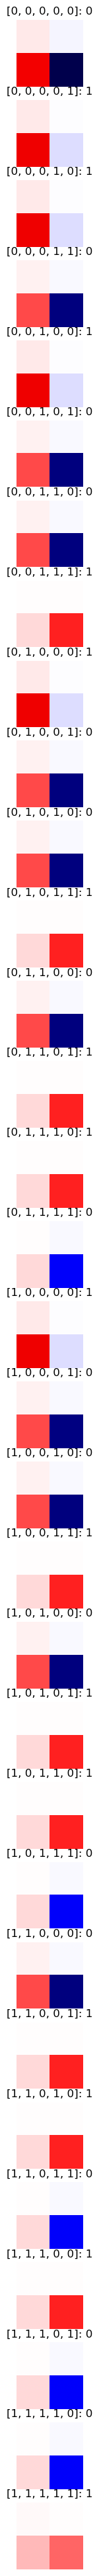

In [328]:
vmax = (model.output.weight.unsqueeze(1) * out2).abs().max()
vmin = -vmax
cmap = 'seismic'

fig, ax = plt.subplots(32, 1, figsize=(7, 50))
for i in range(32):
    ax[i].imshow((model.output.weight * out2[i:i+1,:]).cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(f"{x[i, :5].tolist()}: {y[i].item()}")
    ax[i].axis('off')

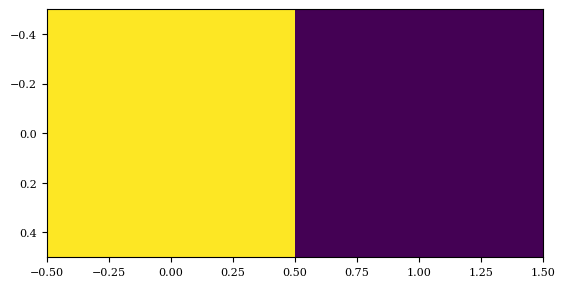

In [50]:
plt.imshow((model.output.weight * out2[0:1,:]).sum(dim=-1).unsqueeze(0).cpu().detach().numpy())

In [81]:
(model.output.weight * out2[:1,:]).sum(dim=-1).unsqueeze(0).cpu().detach().numpy()

array([[-0.56557643, -0.33446813]], dtype=float32)

In [82]:
torch.set_printoptions(linewidth=400)
model.output.weight[:2,:]

tensor([[ 0.3725, -0.8504],
        [-0.6941,  1.0089]], device='cuda:0', grad_fn=<SliceBackward0>)

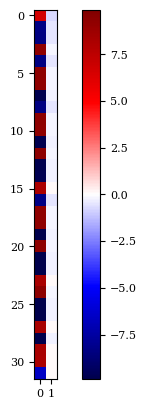

In [509]:
vmax = out3.abs().max().item()
vmin = -vmax
cmap = 'seismic'

plt.imshow(out3.squeeze().cpu().detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()

In [400]:
(model(x).argmax(dim=-1) == y).float().mean()

tensor(0.5000, device='cuda:0')

## t-SNE visualization

### TO DO
- Define representatives of equivalence class for the group of permutations
- Associate to each input sequence a label that correspond to the representative (from 1 to 5)

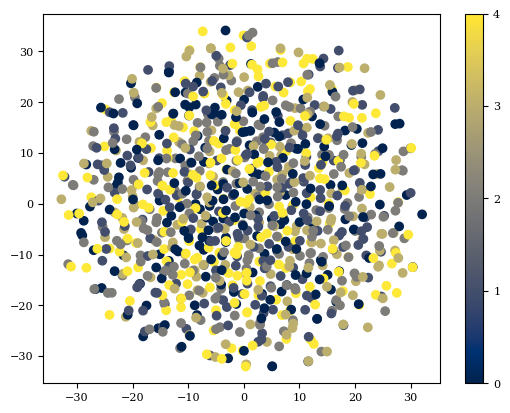

In [84]:
# Define a toy input of N input vectors of dimension 32
# this represents the output after attention or 1st MLP layer for instance
emb_dim = 32
N = 1000
input = np.random.rand(N, 32)  # input vector
target = np.random.randint(low=0, high=5, size=N)  # associated representative elements

# TSNE embeddings
emb = TSNE().fit_transform(input)

cmap = "cividis"
marker = "o"
plt.scatter(emb[:, 0], emb[:, 1], c=target, marker=marker, cmap=cmap)
plt.colorbar(ticks=np.arange(5))
plt.show()

## PCA visualization

### TO DO
Same as above: define representative and associate each point to it, then plot PCA on same figure for with the associated colors

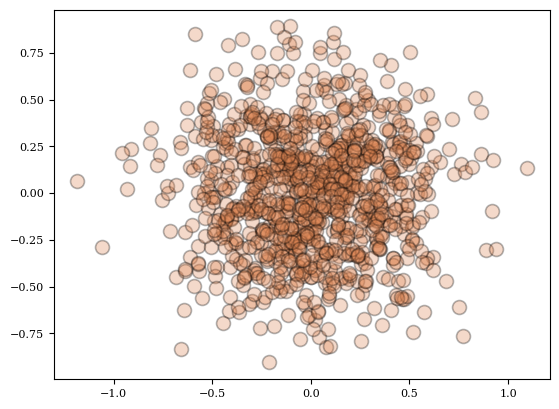

In [85]:
# Define a toy input of N input vectors of dimension 32
# this represents the output after attention or 1st MLP layer for instance
emb_dim = 32
N = 1000
input = np.random.rand(N, 32)  # input vector
target = np.random.randint(low=0, high=5, size=N)  # associated representative elements

# PCA embeddings
emb = PCA().fit_transform(input)


myplot = lambda x, y, color, alpha, marker, ax, label: ax.scatter(
    x=x,
    y=y,
    s=100,
    edgecolors="k",
    color=color,
    alpha=alpha,
    marker=marker,
    linewidths=1.2,
    label=label,
)

# PCA
_, ax = plt.subplots()
myplot(
    x=emb[:, 0],
    y=emb[:, 1],
    color="#dd8452",
    alpha=0.3,
    marker="o",
    ax=ax,
    label="",
)
plt.show()